# 2018 Chicago Crime: Arrest Modeling

This data was pulled from https://data.cityofchicago.org from January 1, 2018, to May 17, 2018.  I used Openrefine to split and clean the address column.  Address was split into four columns which include the block number, direction, street name, and the address suffix.<br>
<br>
When modeling to predict arrests with this database, many biases can come into play based solely on the existence of a record.  For example, the amount of non-arrests for narcottics crimes is in the single digits, despite there being thousands of narcotics crimes.  This is most likely due to the nature of the crime, where a police record is created only when an arrest is made.<br>
<br>
For a simple model, lets see how well we can predict arrests based on the address of the crime given a record was created.

## Load the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("ChicagoCrimes2018.csv")

In [52]:
df.head()

,Date,Block,Address 1,Address 2,Address 3,Address 4,IUCR,Primary Type,Description,Location Description,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,01/01/2018 12:01:00 AM,017XX W 18TH PL,17,W,18TH,PL,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,...,25.0,31,20,NaN,NaN,2018,05/23/2018 04:05:40 PM,NaN,NaN,NaN
1,01/01/2018 12:01:00 AM,054XX S SPAULDING AVE,54,S,SPAULDING,AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,...,14.0,63,20,NaN,NaN,2018,05/23/2018 04:05:40 PM,NaN,NaN,NaN
2,01/01/2018 12:01:00 AM,029XX W LEXINGTON ST,29,W,LEXINGTON,ST,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,...,2.0,27,17,NaN,NaN,2018,05/23/2018 04:05:40 PM,NaN,NaN,NaN
3,01/01/2018 12:01:00 AM,049XX W FLETCHER ST,49,W,FLETCHER,ST,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,...,31.0,19,17,NaN,NaN,2018,05/23/2018 04:05:40 PM,NaN,NaN,NaN
4,01/01/2018 12:01:00 AM,072XX S CALIFORNIA AVE,72,S,CALIFORNIA,AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,DAY CARE CENTER,...,18.0,66,20,1158957.0,1856595.0,2018,05/23/2018 04:00:19 PM,41.762222,-87.692966,"(41.762222436, -87.692965656)"


In [53]:
df.tail()

,Date,Block,Address 1,Address 2,Address 3,Address 4,IUCR,Primary Type,Description,Location Description,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
90691,05/17/2018 11:20:00 PM,005XX W CONGRESS PKWY,5,W,CONGRESS,PKWY,502T,OTHER OFFENSE,TAMPER WITH MOTOR VEHICLE,STREET,...,2.0,28,26,1173014.0,1897914.0,2018,05/24/2018 03:56:11 PM,41.875307,-87.640223,"(41.875306962, -87.640223321)"
90692,05/17/2018 11:40:00 PM,063XX S TROY ST,63,S,TROY,ST,0497,BATTERY,AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON,APARTMENT,...,15.0,66,04B,1156479.0,1862338.0,2018,05/24/2018 03:56:11 PM,41.778032,-87.701893,"(41.778032361, -87.701893399)"
90693,05/17/2018 11:40:00 PM,039XX W ROOSEVELT RD,39,W,ROOSEVELT,RD,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,VEHICLE NON-COMMERCIAL,...,24.0,29,24,1150148.0,1894416.0,2018,05/24/2018 03:56:11 PM,41.866184,-87.724270,"(41.866184058, -87.724269705)"
90694,05/17/2018 11:50:00 PM,001XX E LAKE ST,1,E,LAKE,ST,0620,BURGLARY,UNLAWFUL ENTRY,RESTAURANT,...,42.0,32,05,1177375.0,1901760.0,2018,05/24/2018 03:56:11 PM,41.885763,-87.624095,"(41.885762846, -87.624094929)"
90695,05/17/2018 11:59:00 PM,042XX W AINSLIE ST,42,W,AINSLIE,ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,...,39.0,14,14,1147019.0,1932223.0,2018,05/24/2018 03:56:11 PM,41.969991,-87.734788,"(41.969990507, -87.734787953)"


## Explore the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90696 entries, 0 to 90695
Data columns (total 24 columns):
Date                    90696 non-null object
Block                   90696 non-null object
Address 1               90696 non-null int64
Address 2               90696 non-null object
Address 3               90696 non-null object
Address 4               90696 non-null object
IUCR                    90696 non-null object
Primary Type            90696 non-null object
Description             90696 non-null object
Location Description    90497 non-null object
Arrest                  90696 non-null bool
Domestic                90696 non-null bool
Beat                    90696 non-null int64
District                90696 non-null int64
Ward                    90695 non-null float64
Community Area          90696 non-null int64
FBI Code                90696 non-null object
X Coordinate            90208 non-null float64
Y Coordinate            90208 non-null float64
Year                  

In [5]:
df['Arrest'].head()

0    False
1    False
2    False
3    False
4    False
Name: Arrest, dtype: bool

In [6]:
df['Arrest'].value_counts()

False    72563
True     18133
Name: Arrest, dtype: int64

In [7]:
df['Primary Type'].value_counts().head(10)

THEFT                  21145
BATTERY                17124
CRIMINAL DAMAGE         9562
ASSAULT                 7070
DECEPTIVE PRACTICE      6257
OTHER OFFENSE           6186
NARCOTICS               4585
BURGLARY                3878
MOTOR VEHICLE THEFT     3563
ROBBERY                 3398
Name: Primary Type, dtype: int64

We can visualize this with a count plot, and add in an additional feature of Arrest.  As we will see, non-arrests for narcotics records doesn't even register on the visualization. Narcotics records will most likely influence our model for predicting arrests.

In [18]:
sns.set_style('darkgrid')

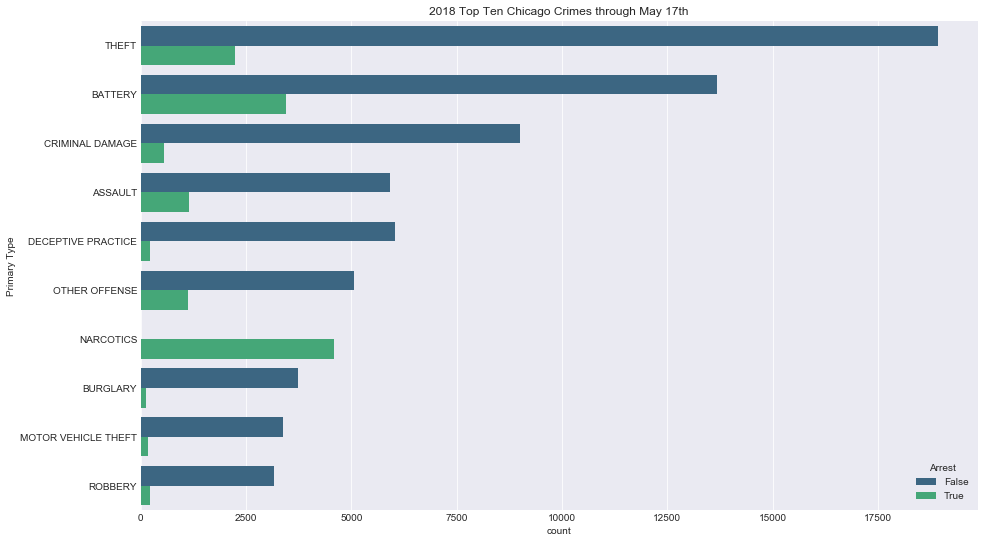

In [38]:
plt.figure(figsize=(15,9))
sns.countplot(y=df['Primary Type'], hue=df['Arrest'], palette='viridis',
              order=df['Primary Type'].value_counts().head(10).index)
plt.title('2018 Top Ten Chicago Crimes through May 17th')

Lets take a look at the streets where the crimes take place.

In [40]:
df['Address 3'].value_counts().head(10)

STATE                       1940
MICHIGAN                    1852
HALSTED                     1258
ASHLAND                     1158
CLARK                        931
WESTERN                      922
MADISON                      877
PULASKI                      868
DR MARTIN LUTHER KING JR     856
KEDZIE                       830
Name: Address 3, dtype: int64

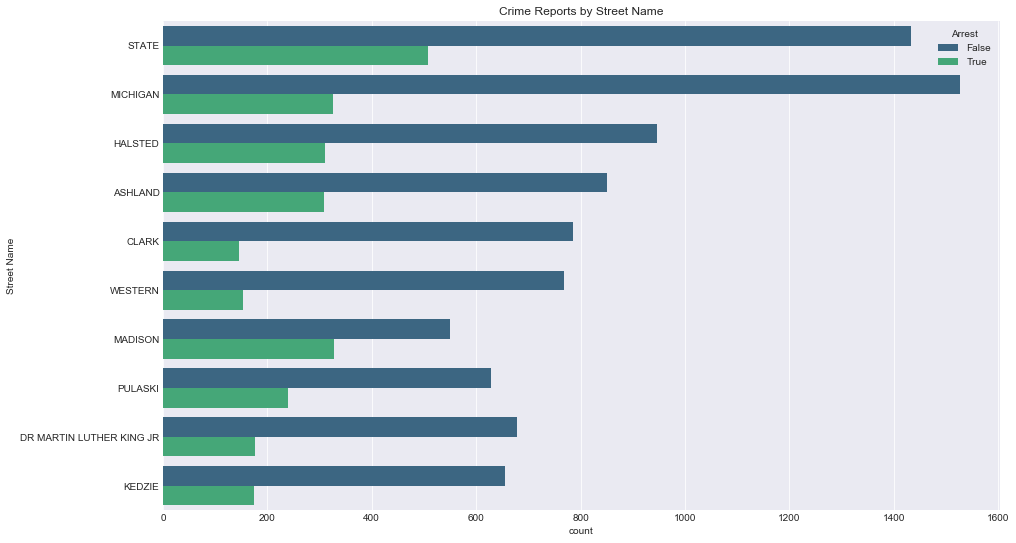

In [54]:
plt.figure(figsize=(15,9))
sns.countplot(y=df['Address 3'], hue=df['Arrest'], palette='viridis',
              order=df['Address 3'].value_counts().head(10).index)
plt.ylabel('Street Name')
plt.title('Crime Reports by Street Name')

In [56]:
df['Location Description'].value_counts().head(10)

STREET                            19820
RESIDENCE                         15409
APARTMENT                         12261
SIDEWALK                           6347
OTHER                              3587
PARKING LOT/GARAGE(NON.RESID.)     2711
RESTAURANT                         2708
SMALL RETAIL STORE                 2654
DEPARTMENT STORE                   1707
SCHOOL, PUBLIC, BUILDING           1638
Name: Location Description, dtype: int64

Arrests will be our target and currently is a boolean object.  We can convert it to a target '0' and '1' for modeling.

In [10]:
df['Arrest']  = df['Arrest'].apply(lambda x: 1 if x==True else 0)

In [11]:
df['Arrest'].value_counts()

0    72563
1    18133
Name: Arrest, dtype: int64

In [12]:
y=df['Arrest']

In [13]:
cat_feats = ['Address 1', 'Address 2', 'Address 3', 'Address 4']

In [14]:
X = df[cat_feats]

In [15]:
X.head()

,Address 1,Address 2,Address 3,Address 4
0,17,W,18TH,PL
1,54,S,SPAULDING,AVE
2,29,W,LEXINGTON,ST
3,49,W,FLETCHER,ST
4,72,S,CALIFORNIA,AVE


In [16]:
X =  pd.DataFrame(pd.get_dummies(X, columns=cat_feats, drop_first=True))

In [17]:
X.head()

,Address 1_1,Address 1_2,Address 1_3,Address 1_4,Address 1_5,Address 1_6,Address 1_7,Address 1_8,Address 1_9,Address 1_10,...,Address 4_PL,Address 4_PLAISANCE,Address 4_PLZ,Address 4_RD,Address 4_SB,Address 4_SQ,Address 4_ST,Address 4_TER,Address 4_W,Address 4_WAY
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
from sklearn.cross_validation import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [20]:
y_test.value_counts()

0    21797
1     5412
Name: Arrest, dtype: int64

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [22]:
logit = LogisticRegression()
logit.fit(X_train,y_train)
preds = logit.predict(X_test)
preds_bins = logit.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, preds_bins)


print confusion_matrix(y_test,preds)
print'\n'
print classification_report(y_test, preds)
print 'AUC: ', auc

[[21729    68]
 [ 5291   121]]


             precision    recall  f1-score   support

          0       0.80      1.00      0.89     21797
          1       0.64      0.02      0.04      5412

avg / total       0.77      0.80      0.72     27209

AUC:  0.643512539833


# Add the crime (IUCR is the crime codes from CPD)


In [23]:
cat_feats = ['Address 1', 'Address 2', 'Address 3', 'Address 4', 'IUCR']
X = df[cat_feats]
X = pd.DataFrame(pd.get_dummies(X, columns=cat_feats, drop_first=True))

y = df['Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

logit = LogisticRegression()
logit.fit(X_train,y_train)
preds = logit.predict(X_test)
preds_bins = logit.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, preds_bins)


print confusion_matrix(y_test,preds)
print'\n'
print classification_report(y_test, preds)
print 'AUC: ', auc

[[21312   485]
 [ 2379  3033]]


             precision    recall  f1-score   support

          0       0.90      0.98      0.94     21797
          1       0.86      0.56      0.68      5412

avg / total       0.89      0.89      0.89     27209

AUC:  0.890257720054
